In [10]:

####Rene 7_30_2021 update 4/1/2022
# Import the os module
import os
import pandas as pd
import numpy as np

#This file is for development. Main functions are embedded here.

#Isotope pattern matching algorithm for LC-FTMS Data
# Change the current working directory
os.chdir('/Users/boiteaur/Desktop/CoreMS_metallomics/CoreMS')

###### Set file folder and THERMO RAW file name here:
file_location='/Users/boiteaur/Desktop/Major projects/Bermuda Atlantic Time Series data processing/Thermo RAW data'
files=os.listdir('/Users/boiteaur/Desktop/Major projects/Bermuda Atlantic Time Series data processing/Thermo RAW data')


import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("./")

from pathlib import Path

import matplotlib.pyplot as plt
# from PySide2.QtWidgets import QFileDialog, QApplication
# from PySide2.QtCore import Qt

from corems.mass_spectra.input import rawFileReader
from corems.molecular_id.factory.classification import HeteroatomsClassification, Labels
from corems.molecular_id.search.priorityAssignment import OxygenPriorityAssignment
from corems.molecular_id.search.molecularFormulaSearch import SearchMolecularFormulas
from corems.encapsulation.factory.parameters import MSParameters
from corems.mass_spectrum.calc.Calibration import MzDomainCalibration

import matplotlib.backends.backend_pdf

#Set peak detection threshold method

refmasslist = Path.cwd() / "tests/tests_data/ftms/nom_pos.ref"

MSParameters.mass_spectrum.threshold_method = 'signal_noise'
MSParameters.mass_spectrum.s2n_threshold = 2
MSParameters.ms_peak.peak_min_prominence_percent = 0.001

MSParameters.molecular_search.error_method = 'None'
MSParameters.molecular_search.min_ppm_error = -0.25
MSParameters.molecular_search.max_ppm_error = 0.25

MSParameters.molecular_search.isProtonated = True
MSParameters.molecular_search.isRadical = False
MSParameters.molecular_search.isAdduct = False

MSParameters.molecular_search.score_method = "prob_score"
MSParameters.molecular_search.output_score_method = "prob_score"

#Read in sample list and load MS data

file="RMB_190828_BATS20_5m"

MSfiles={}

parser = rawFileReader.ImportMassSpectraThermoMSFileReader(file_location+'/'+file)
MSfiles[file]=parser


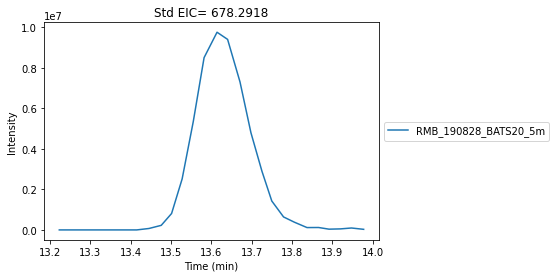

In [11]:
#QC control 

stdmass=678.2918
std_timerange=[13.2,14]

#QC control 

#stdmass=389.1960
#std_timerange=[5,30]

area=[]
rt=[]
fig=plt.figure()
ax=plt.subplot(111)
ax.set(xlabel='Time (min)',ylabel='Intensity',title='Std EIC= '+str(stdmass))

for file in MSfiles.keys():
    EIC=MSfiles[file].get_eics(target_mzs=[stdmass],tic_data={},peak_detection=False,smooth=False)
    df=pd.DataFrame({'EIC':EIC[0][stdmass].eic,'time':EIC[0][stdmass].time})
    df_sub=df[df['time'].between(std_timerange[0],std_timerange[1])]
    area.append(sum(df_sub['EIC']))
    rt.append(df_sub.time[df_sub.EIC==df_sub.EIC.max()].max())
    ax.plot(df_sub['time'],df_sub['EIC'],label=file)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#plt.savefig('Fig1_qcplot.eps', format='eps')

plt.show()

In [14]:
#Function to build formula assignment lists
#Retrieve TIC for MS1 scans over the time range between 'timestart' and 'timestop' 
interval=2
timerange=[18,30]

B=21 #magnetic field strength
T=0.6 #transient time

def lcmsformula(parser,interval,timerange):
    tic=parser.get_tic(ms_type='MS')[0]
    tic_df=pd.DataFrame({'time': tic.time,'scan': tic.scans})

    times=list(range(timerange[0],timerange[1],interval))

    results=[]
    
    for timestart in times:

        scans=tic_df[tic_df.time.between(timestart,timestart+interval)].scan.tolist()
        #Now, get an average mass spectrum and list the centroided m/z values of the spectrum. One of these should be the molecule of interest.
        mass_spectrum = parser.get_average_mass_spectrum_by_scanlist(scans)
        mass_spectrum.filter_by_min_resolving_power(B, T)
    
        mass_spectrum.settings.min_calib_ppm_error = 2
        mass_spectrum.settings.max_calib_ppm_error = -2
        #mass_spectrum.mass_spectrum.settings.calib_sn_threshold
        #mass_spectrum.mass_spectrum.settings.calib_pol_order
        #mass_spectrum.recalibrate_mass_spectrum(mass_spectrum, imzmeas, mzrefs, order=2)
        #MzDomainCalibration(mass_spectrum, ref_file_location).run()
        calfn = MzDomainCalibration(mass_spectrum, refmasslist)
        ref_mass_list_fmt = calfn.load_ref_mass_list(refmasslist)

        imzmeas, mzrefs = calfn.find_calibration_points(mass_spectrum, ref_mass_list_fmt,
                                                    calib_ppm_error_threshold=(0, 2.0),
                                                    calib_snr_threshold=4)

        calfn.recalibrate_mass_spectrum(mass_spectrum, imzmeas, mzrefs, order=2)


        SearchMolecularFormulas(mass_spectrum, first_hit=False).run_worker_mass_spectrum()

        mass_spectrum.percentile_assigned(report_error=True)

        assignments=mass_spectrum.to_dataframe()

        assignments['Time']=timestart

        results.append(assignments)
        #results(timestart)=assignments[assignments['Calculated m/z']>1].filter(['m/z','corr','Peak Height','Confidence Score','Molecular Formula','Time']))
    
    results=pd.concat(results,ignore_index=True)

    return(results)

In [15]:

MSParameters.molecular_search.url_database = None
MSParameters.molecular_search.min_dbe = -1
MSParameters.molecular_search.max_dbe = 20

MSParameters.molecular_search.usedAtoms['C'] = (1,50)
MSParameters.molecular_search.usedAtoms['H'] = (4,100)
MSParameters.molecular_search.usedAtoms['O'] = (1,20)
MSParameters.molecular_search.usedAtoms['N'] = (0,4)
MSParameters.molecular_search.usedAtoms['S'] = (0,0)
MSParameters.molecular_search.usedAtoms['P'] = (0,0)
MSParameters.molecular_search.usedAtoms['Na'] = (0,1)

#MSpeak highest confidence molecular formula. 

#### Core feature extraction function.
masterresults={}

for file in MSfiles:
    print(file)
    results=lcmsformula(MSfiles[file],interval,timerange)
    results['File']=file
    masterresults[file]=results

#This will create masterresults_df from above masterresults and save
masterresults_df=pd.concat(masterresults.values())
masterresults_df.to_csv(file_location+'masterresults_3_CHON.csv')

RMB_190828_BATS20_5m
MS Obj loaded - 1258 peaks found.
MS Obj loaded - 1258 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
160 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.026 ppm
minimize function performed 3009 fn evals and 68 iterations
'runworker'  300.58 ms


Loading molecular formula database: 163718it [00:13, 11878.13it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Na": 1}, (de)protonated : 100%|██████████| 200/200 [00:02<00:00, 66.73it/s]


'run_molecular_formula'  17303.96 ms
1183 assigned peaks and 75 unassigned peaks, total  = 94.04 %, relative abundance = 95.20 %, RMS error (best candidate) (ppm) = 0.050
MS Obj loaded - 1266 peaks found.
MS Obj loaded - 1266 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
157 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.025 ppm
minimize function performed 3040 fn evals and 68 iterations
'runworker'  140.70 ms


Loading molecular formula database: 163718it [00:15, 10857.82it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Na": 1}, (de)protonated : 100%|██████████| 200/200 [00:04<00:00, 49.24it/s]


'run_molecular_formula'  19552.76 ms
1177 assigned peaks and 89 unassigned peaks, total  = 92.97 %, relative abundance = 91.29 %, RMS error (best candidate) (ppm) = 0.057
MS Obj loaded - 1291 peaks found.
MS Obj loaded - 1291 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
151 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.023 ppm
minimize function performed 467 fn evals and 10 iterations
'runworker'  416.10 ms


Loading molecular formula database: 163718it [00:16, 10054.89it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Na": 1}, (de)protonated : 100%|██████████| 200/200 [00:03<00:00, 50.44it/s]


'run_molecular_formula'  21004.73 ms
1143 assigned peaks and 148 unassigned peaks, total  = 88.54 %, relative abundance = 83.87 %, RMS error (best candidate) (ppm) = 0.049
MS Obj loaded - 1326 peaks found.
MS Obj loaded - 1326 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
119 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.026 ppm
minimize function performed 462 fn evals and 10 iterations
'runworker'  170.61 ms


Loading molecular formula database: 163718it [00:16, 10124.86it/s]
Started molecular formula search for class {"N": 4, "O": 20, "Na": 1}, (de)protonated : 100%|██████████| 200/200 [00:03<00:00, 53.68it/s]


'run_molecular_formula'  20340.81 ms
1097 assigned peaks and 229 unassigned peaks, total  = 82.73 %, relative abundance = 85.24 %, RMS error (best candidate) (ppm) = 0.048
MS Obj loaded - 3006 peaks found.
MS Obj loaded - 3006 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
117 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.033 ppm
minimize function performed 484 fn evals and 10 iterations
'runworker'  487.19 ms


Loading molecular formula database: 163718it [00:19, 8193.50it/s] 
Started molecular formula search for class {"N": 4, "O": 20, "Na": 1}, (de)protonated : 100%|██████████| 200/200 [00:06<00:00, 28.63it/s]


'run_molecular_formula'  27766.47 ms
1421 assigned peaks and 1585 unassigned peaks, total  = 47.27 %, relative abundance = 75.38 %, RMS error (best candidate) (ppm) = 0.077
MS Obj loaded - 2648 peaks found.
MS Obj loaded - 2648 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
65 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.040 ppm
minimize function performed 662 fn evals and 15 iterations
'runworker'  202.42 ms


Loading molecular formula database: 163718it [00:18, 8861.85it/s] 
Started molecular formula search for class {"N": 4, "O": 20, "Na": 1}, (de)protonated : 100%|██████████| 200/200 [00:07<00:00, 28.43it/s]


'run_molecular_formula'  26116.10 ms
1030 assigned peaks and 1618 unassigned peaks, total  = 38.90 %, relative abundance = 69.65 %, RMS error (best candidate) (ppm) = 0.081


10783
2300
57010
141010
194010
338010
407010


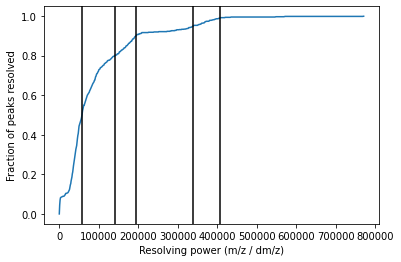

In [16]:
#Make plots showing required resolving power.

#This will load a previous masterresults_df
#masterresults_df=pd.read_csv(file_location+'masterresults_2.csv')

#masterresults_df=masterresults_df[masterresults_df['Time']<25]
#masterresults_df=masterresults_df[masterresults_df['Time']>3]

diff_summary=[]
res_summary=[]
for time in masterresults_df['Time'].unique():
    
    result=masterresults_df[masterresults_df['Time']==time]

    for file in masterresults_df['File'].unique():
        result_sub=result[result['File']==file]

        #mzdiff=result_sub['m/z'].sort_values(ascending=True).diff().iloc[1:]
        #mzdiff_res=result_sub['m/z'].iloc[1:]/mzdiff
        differences=result_sub['m/z'].sort_values(ascending=True).diff()
        #Resolve from peaks on either side
        mzdiff=pd.DataFrame({'left':differences[1:-1].to_list(),'right':differences[2:].to_list()})
        mzdiff=mzdiff.min(axis=1)
        mzdiff_res=result_sub['m/z'].iloc[1:-1]/mzdiff*3

        diff_summary.extend(mzdiff.tolist())
        res_summary.extend(mzdiff_res[mzdiff_res<1e6].tolist())

res=list(range(10,int(max(res_summary)),1000))

count=[]
for i in res:
    count.append(len([element for element in res_summary if element<i])/len(res_summary))

print(len(diff_summary))
print(len([element for element in diff_summary if element<0.01]))

plt.plot(res,count)
for i in [0.5,0.8,0.9,0.95,0.99]:
    current=abs(np.array(count)-i).tolist()
    print(res[current.index(min(current))])
    plt.axvline(res[current.index(min(current))],color='black')
plt.xlabel('Resolving power (m/z / dm/z)')
plt.ylabel('Fraction of peaks resolved')

plt.show()



5975


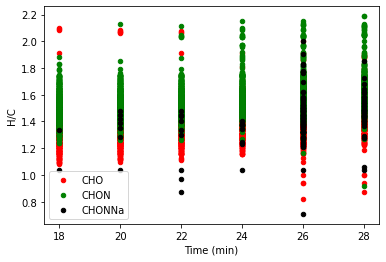

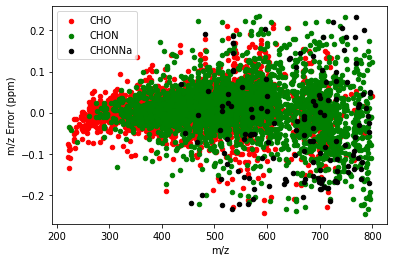

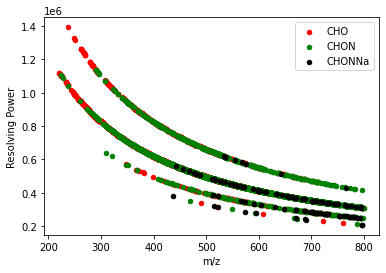

In [17]:
# Plot clean results. 

results=masterresults_df[(masterresults_df['m/z']<800) & (masterresults_df['Is Isotopologue']==0)]
print(len(results))

results['N']=results['N'].fillna(0)
results['O']=results['O'].fillna(0)
results['Na']=results['Na'].fillna(0)
results['O/C']=results['O']/results['C']
results['H/C']=results['H']/results['C']
results['N/C']=results['N']/results['C']

results['mol_class']='None'
results['mol_class'][results['N']==0]='CHO'
results['mol_class'][results['N']>0.5]='CHON'
results['mol_class'][results['N']>0.5]='CHON'
results['mol_class'][results['Na']>0.5]='CHONNa'


#results['mol_class'][(results['O/C']<0.6) & (results['H/C']>1.32) & (results['N/C']<0.126)]='Lipid'
#results['mol_class'][(results['O/C']>0.12) & (results['O/C']<0.6) & (results['H/C']>0.9) & (results['H/C']<2.5) & (results['N/C']>0.126) & (results['N/C']<0.7) & (results['N']>0.5)]='Protein'
#results['mol_class'][(results['O/C']>0.6) & (results['O/C']<1) & (results['H/C']>1.2) & (results['H/C']<2.5) & (results['N/C']>0.2) & (results['N/C']<0.7) & (results['N']>0.5)]='Protein'
#results['mol_class'][(results['O/C']>0.61) & (results['H/C']>1.45) & (results['N/C']>0.07) & (results['N/C']<0.2) & (results['N']>0.5) & (results['O']>2.5)]='Amino Sugar'
#results['mol_class'][(results['O/C']>0.8) & (results['H/C']>1.65) & (results['H/C']<2.7) & (results['N']==0)]='Carbohydrate'
#results['mol_class'][(results['O/C']<1.15) & (results['H/C']<1.32) & (results['N/C']>0.07) & (results['N/C']<0.126)]='Phytochemical'
#results['mol_class'][(results['O/C']>0.61) & (results['H/C']>1.45) & (results['N/C']>0.07) & (results['N/C']<0.2) & (results['N']>0.5) & (results['O']>2.5)]='Oxyaromatic'

presults=results

colors = {'CHO':'red', 'CHON':'green', 'CHOS':'blue', 'CHONS':'yellow','CHONNa':'black'}

grouped=presults.groupby('mol_class')

fig, (ax) = plt.subplots(1)
for key, group in grouped:
    group.plot(ax=ax,kind='scatter',x='Time',y='H/C',color=colors[key],label=key)

ax.set(xlabel='Time (min)')

fig, (ax) = plt.subplots(1)
for key, group in grouped:
    group.plot(ax=ax,kind='scatter',x='m/z',y='m/z Error (ppm)',color=colors[key],label=key)


fig, (ax) = plt.subplots(1)
for key, group in grouped:
    group.plot(ax=ax,kind='scatter',x='m/z',y='Resolving Power',color=colors[key],label=key)

#ax=presults.plot.scatter(x='Time',y='H/C',s=presults['Peak Height']/4000,c='Time',cmap='viridis')
#ax.set(xlabel='Time (min)')
#presults.plot.scatter(x='Time',y='O/C',s=presults['Peak Height']/4000,c='Time',cmap='viridis')
#presults.plot.scatter(x='O/C',y='H/C',s=presults['Peak Height']/4000,c='Time',cmap='viridis')
#presults.plot.scatter(x='m/z',y='m/z Error (ppm)',s=presults['Peak Height']/4000,c='Time',cmap='viridis')
#presults.plot.scatter(x='m/z',y='DBE',s=presults['Peak Height']/4000,c='Time',cmap='viridis')

plt.show()


Average Total: 10795.0
Unique  molecular formula #: 2858
Unique good molecular formula #: 2662
Unique m/z peaks: 6116


<AxesSubplot:xlabel='Time', ylabel='Peaks'>

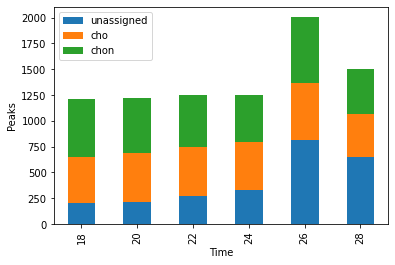

In [18]:

#Plot average number and classes of peaks assigned over time. 
nfiles=len(MSfiles)

#print(results.columns.values)
print('Average Total:', len(masterresults_df)/nfiles)
print('Unique  molecular formula #:', len(masterresults_df['Molecular Formula'].unique()))
Assignedlist=masterresults_df[(masterresults_df['m/z']<800)]
print('Unique good molecular formula #:', len(Assignedlist['Molecular Formula'].unique()))
print('Unique m/z peaks:', len(masterresults_df['m/z'].round(3).unique()))

assign_summary=[]
for time in masterresults_df['Time'].unique():
    result=masterresults_df[(masterresults_df['Time']==time) & (masterresults_df['m/z']<800)]
    total=len(result)/nfiles
    result=result[result['Molecular Formula'].isin(results['Molecular Formula'])]
    attrib=len(result[result['C']>1])/nfiles
    cho=len(result[(result['C']>1) & (result['N'].isnull())])/nfiles
    chon=len(result[result['N']>0])/nfiles
    unassigned=total-attrib

    assign_summary.append({'Time':time,'total':total,'assigned':attrib,'cho':cho,'chon':chon,'unassigned':unassigned,'frac':attrib/total})
    #mzdiff=result['m/z'].sort_values(ascending=True).diff().iloc[1:]/result['m/z'].sort_values(ascending=True).iloc[1:]*1E6


df=pd.DataFrame(assign_summary)

df.plot.bar(x='Time',y=['unassigned','cho','chon'],stacked=True,ylabel='Peaks')


In [19]:

MSParameters.molecular_search.min_dbe = 0
MSParameters.molecular_search.max_dbe = 20

MSParameters.molecular_search.usedAtoms['C'] = (1,50)
MSParameters.molecular_search.usedAtoms['H'] = (4,100)
MSParameters.molecular_search.usedAtoms['O'] = (1,20)
MSParameters.molecular_search.usedAtoms['N'] = (0,4)
MSParameters.molecular_search.usedAtoms['S'] = (0,1)
MSParameters.molecular_search.usedAtoms['P'] = (0,0)
MSParameters.molecular_search.usedAtoms['Na'] = (0,1)
# 

#### Core feature extraction function.
masterresults_chons={}

for file in MSfiles:
    print(file)
    results=lcmsformula(MSfiles[file],interval,timerange)
    results['File']=file
    masterresults_chons[file]=results

#This will create masterresults_df from above masterresults and save
masterresults_chons_df=pd.concat(masterresults_chons.values())
masterresults_chons_df.to_csv(file_location+'masterresults_CHONS.csv')

RMB_190828_BATS20_5m
MS Obj loaded - 1258 peaks found.
MS Obj loaded - 1258 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
160 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.026 ppm
minimize function performed 3009 fn evals and 68 iterations


100%|██████████| 200/200 [00:00<00:00, 415.79it/s]


Started database insert using 5128 iterations for a total of 256360 rows


5128it [02:19, 36.73it/s]


'runworker'  140950.46 ms


Loading molecular formula database: 237117it [00:25, 9192.32it/s] 
Started molecular formula search for class {"N": 1, "P": 1, "O": 18, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:06<00:00, 48.21it/s]        
Loading molecular formula database: 238840it [00:29, 8021.36it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "P": 1, "O": 15, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:04<00:00, 62.95it/s]
Loading molecular formula database: 158449it [00:17, 9238.47it/s] 
Started molecular formula search for class {"N": 4, "S": 1, "P": 1, "O": 20, "Na": 1}, (de)protonated : 100%|██████████| 200/200 [00:02<00:00, 67.15it/s]


'run_molecular_formula'  228515.27 ms
1211 assigned peaks and 47 unassigned peaks, total  = 96.26 %, relative abundance = 97.12 %, RMS error (best candidate) (ppm) = 0.054
MS Obj loaded - 1266 peaks found.
MS Obj loaded - 1266 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
157 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.025 ppm
minimize function performed 3040 fn evals and 68 iterations
'runworker'  195.23 ms


Loading molecular formula database: 237117it [00:23, 9961.01it/s] 
Started molecular formula search for class {"N": 1, "P": 1, "O": 18, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:05<00:00, 53.62it/s]        
Loading molecular formula database: 238840it [00:27, 8674.26it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "P": 1, "O": 15, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:05<00:00, 53.29it/s]
Loading molecular formula database: 158449it [00:17, 9153.84it/s] 
Started molecular formula search for class {"N": 4, "S": 1, "P": 1, "O": 20, "Na": 1}, (de)protonated : 100%|██████████| 200/200 [00:02<00:00, 71.28it/s]


'run_molecular_formula'  83758.52 ms
1219 assigned peaks and 47 unassigned peaks, total  = 96.29 %, relative abundance = 93.87 %, RMS error (best candidate) (ppm) = 0.061
MS Obj loaded - 1291 peaks found.
MS Obj loaded - 1291 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
151 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.023 ppm
minimize function performed 467 fn evals and 10 iterations
'runworker'  198.05 ms


Loading molecular formula database: 237117it [00:22, 10343.33it/s]
Started molecular formula search for class {"N": 1, "P": 1, "O": 18, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:05<00:00, 55.08it/s]        
Loading molecular formula database: 238840it [00:27, 8556.71it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "P": 1, "O": 15, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:04<00:00, 61.21it/s]
Loading molecular formula database: 158449it [00:18, 8424.85it/s] 
Started molecular formula search for class {"N": 4, "S": 1, "P": 1, "O": 20, "Na": 1}, (de)protonated : 100%|██████████| 200/200 [00:03<00:00, 64.18it/s]


'run_molecular_formula'  84252.70 ms
1211 assigned peaks and 80 unassigned peaks, total  = 93.80 %, relative abundance = 91.51 %, RMS error (best candidate) (ppm) = 0.057
MS Obj loaded - 1326 peaks found.
MS Obj loaded - 1326 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
119 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.026 ppm
minimize function performed 462 fn evals and 10 iterations
'runworker'  226.26 ms


Loading molecular formula database: 237117it [00:22, 10499.94it/s]
Started molecular formula search for class {"N": 1, "P": 1, "O": 18, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:06<00:00, 48.15it/s]        
Loading molecular formula database: 238840it [00:30, 7876.02it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "P": 1, "O": 15, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:05<00:00, 56.25it/s]
Loading molecular formula database: 158449it [00:17, 9204.71it/s] 
Started molecular formula search for class {"N": 4, "S": 1, "P": 1, "O": 20, "Na": 1}, (de)protonated : 100%|██████████| 200/200 [00:03<00:00, 56.37it/s]


'run_molecular_formula'  86470.71 ms
1211 assigned peaks and 115 unassigned peaks, total  = 91.33 %, relative abundance = 91.77 %, RMS error (best candidate) (ppm) = 0.062
MS Obj loaded - 3006 peaks found.
MS Obj loaded - 3006 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
117 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.033 ppm
minimize function performed 484 fn evals and 10 iterations
'runworker'  199.04 ms


Loading molecular formula database: 237117it [00:35, 6760.70it/s] 
Started molecular formula search for class {"N": 1, "P": 1, "O": 18, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:15<00:00, 18.84it/s]        
Loading molecular formula database: 238840it [01:40, 2382.04it/s]
Started molecular formula search for class {"N": 3, "S": 1, "P": 1, "O": 15, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:36<00:00,  8.21it/s]
Loading molecular formula database: 158449it [00:38, 4085.42it/s]
Started molecular formula search for class {"N": 4, "S": 1, "P": 1, "O": 20, "Na": 1}, (de)protonated : 100%|██████████| 200/200 [00:18<00:00, 10.99it/s]


'run_molecular_formula'  246819.27 ms
1796 assigned peaks and 1210 unassigned peaks, total  = 59.75 %, relative abundance = 84.24 %, RMS error (best candidate) (ppm) = 0.089
MS Obj loaded - 2648 peaks found.
MS Obj loaded - 2648 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
65 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.040 ppm
minimize function performed 662 fn evals and 15 iterations
'runworker'  520.16 ms


Loading molecular formula database: 237117it [00:52, 4512.84it/s]
Started molecular formula search for class {"N": 1, "P": 1, "O": 18, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:23<00:00, 12.65it/s]        
Loading molecular formula database: 238840it [01:04, 3706.94it/s]
Started molecular formula search for class {"N": 3, "S": 1, "P": 1, "O": 15, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:22<00:00, 13.13it/s]
Loading molecular formula database: 158449it [00:39, 3969.30it/s]
Started molecular formula search for class {"N": 4, "S": 1, "P": 1, "O": 20, "Na": 1}, (de)protonated : 100%|██████████| 200/200 [00:13<00:00, 14.92it/s]


'run_molecular_formula'  219428.93 ms
1366 assigned peaks and 1282 unassigned peaks, total  = 51.59 %, relative abundance = 79.45 %, RMS error (best candidate) (ppm) = 0.092


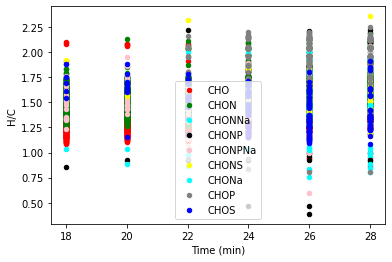

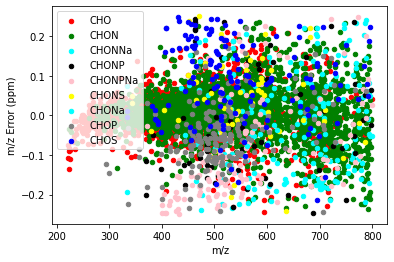

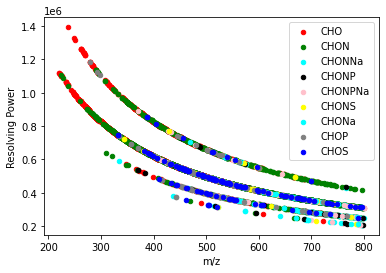

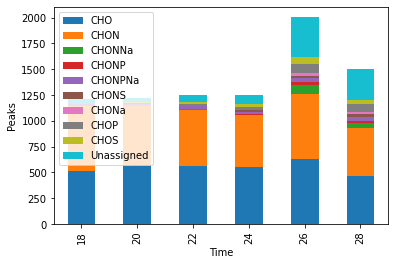

In [48]:
# Plot clean results. 
allresults=masterresults_chons_df[(masterresults_chons_df['m/z']<800)]

allresults['N']=allresults['N'].fillna(0)
allresults['O']=allresults['O'].fillna(0)
allresults['S']=allresults['S'].fillna(0)
allresults['P']=allresults['P'].fillna(0)
allresults['Na']=allresults['Na'].fillna(0)

allresults['mol_class']='Unassigned'
allresults['mol_class'][allresults['C']>0]='CHO'
allresults['mol_class'][(allresults['C']>0) & (allresults['N']>0.5)]='CHON'
allresults['mol_class'][(allresults['C']>0) & (allresults['S']>0.5)]='CHOS'
allresults['mol_class'][(allresults['C']>0) & (allresults['P']>0.5)]='CHOP'
allresults['mol_class'][(allresults['C']>0) & (allresults['Na']>0.5)]='CHONa'
allresults['mol_class'][(allresults['C']>0) & (allresults['S']>0.5) & (allresults['N']>0.5)]='CHONS'
allresults['mol_class'][(allresults['C']>0) & (allresults['P']>0.5) & (allresults['N']>0.5)]='CHONP'
allresults['mol_class'][(allresults['C']>0) & (allresults['Na']>0.5) & (allresults['N']>0.5)]='CHONNa'
allresults['mol_class'][(allresults['C']>0) & (allresults['P']>0.5) & (allresults['Na']>0.5) & (allresults['N']>0.5)]='CHONPNa'


results= allresults[allresults['Is Isotopologue']==0]
results['O/C']=results['O']/results['C']
results['H/C']=results['H']/results['C']
results['N/C']=results['N']/results['C']

presults=results

colors = {'CHO':'red', 'CHON':'green', 'CHOS':'blue', 'CHONS':'yellow', 'CHONP':'black', 'CHONNa':'cyan','CHONPNa':'pink','CHONa':'aqua','CHOP':'gray'}

grouped=presults.groupby('mol_class')

fig, (ax) = plt.subplots(1)
for key, group in grouped:
    group.plot(ax=ax,kind='scatter',x='Time',y='H/C',color=colors[key],label=key)

ax.set(xlabel='Time (min)')

fig, (ax) = plt.subplots(1)
for key, group in grouped:
    group.plot(ax=ax,kind='scatter',x='m/z',y='m/z Error (ppm)',color=colors[key],label=key)


fig, (ax) = plt.subplots(1)
for key, group in grouped:
    group.plot(ax=ax,kind='scatter',x='m/z',y='Resolving Power',color=colors[key],label=key)
    
assign_summary=[]
for time in allresults['Time'].unique():
    current={}
    current['Time']=time
    for mol_class in sorted(allresults['mol_class'].unique()):
        current[mol_class]=len(allresults[(allresults['mol_class']==mol_class) & (allresults['Time']==time)])
    assign_summary.append(current)
df=pd.DataFrame(assign_summary)

df.plot.bar(x='Time',y=df.columns[1:],stacked=True,ylabel='Peaks')

plt.show()



Average Total: 10795.0
Unique  molecular formula #: 3695
Unique good molecular formula #: 0
Unique m/z peaks: 6116


<AxesSubplot:xlabel='Time', ylabel='Peaks'>

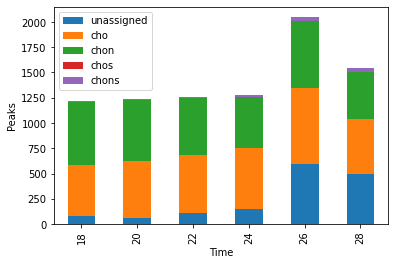

In [26]:

#Plot average number and classes of peaks assigned over time. 
nfiles=len(MSfiles)

#print(results.columns.values)
print('Average Total:', len(masterresults_chons_df)/nfiles)
print('Unique  molecular formula #:', len(masterresults_chons_df['Molecular Formula'].unique()))
Assignedlist=masterresults_chons_df[(masterresults_chons_df['m/z Error (ppm)']>0.35) & (masterresults_chons_df['m/z Error (ppm)']<1.5) & (masterresults_chons_df['m/z']<800)]
print('Unique good molecular formula #:', len(Assignedlist['Molecular Formula'].unique()))
print('Unique m/z peaks:', len(masterresults_chons_df['m/z'].round(3).unique()))

assign_summary=[]
for time in masterresults_chons_df['Time'].unique():
    result=masterresults_chons_df[(masterresults_chons_df['Time']==time) & (masterresults_chons_df['m/z']<800)]
    total=len(result)/nfiles
    result=result[result['Molecular Formula'].isin(results['Molecular Formula'])]
    attrib=len(result[result['C']>1])/nfiles
    
    cho=len(results[results['mol_class']='CHO'])/nfiles
    chon=len(result[result['N']>0])/nfiles
    chos=len(result[(result['S']>0) & (result['N']<0.5)])/nfiles
    chons=len(result[(result['S']>0) & (result['N']>0.5)])/nfiles

    unassigned=total-attrib

    assign_summary.append({'Time':time,'total':total,'assigned':attrib,'cho':cho,'chon':chon,'chos':chos,'chons':chons,'unassigned':unassigned,'frac':attrib/total})
    #mzdiff=result['m/z'].sort_values(ascending=True).diff().iloc[1:]/result['m/z'].sort_values(ascending=True).iloc[1:]*1E6


df=pd.DataFrame(assign_summary)

df.plot.bar(x='Time',y=['unassigned','cho','chon','chos','chons'],stacked=True,ylabel='Peaks')

In [ ]:
MSParameters.molecular_search.min_dbe = 0
MSParameters.molecular_search.max_dbe = 20

MSParameters.molecular_search.usedAtoms['C'] = (1,50)
MSParameters.molecular_search.usedAtoms['H'] = (4,100)
MSParameters.molecular_search.usedAtoms['O'] = (1,20)
MSParameters.molecular_search.usedAtoms['N'] = (0,4)
MSParameters.molecular_search.usedAtoms['P'] = (0,1)
MSParameters.molecular_search.usedAtoms['S'] = (0,0)
MSParameters.molecular_search.usedAtoms['Cl'] = (0,0)
MSParameters.molecular_search.usedAtoms['I'] = (0,0)
MSParameters.molecular_search.usedAtoms['Fe'] = (0,0)
MSParameters.molecular_search.usedAtoms['Cu'] = (0,0)
MSParameters.molecular_search.usedAtoms['Na'] = (0,0)



#### Core feature extraction function.
masterresults={}

for file in MSfiles:
    print(file)
    results=lcmsformula(MSfiles[file],interval,timerange)
    results['File']=file
    masterresults[file]=results

#This will create masterresults_df from above masterresults and save
masterresults_df=pd.concat(masterresults.values())
#masterresults_df.to_csv(file_location+'masterresults_3_CHON.csv')

In [ ]:
# Plot clean results. 
masterresults_df=pd.concat(masterresults.values())
masterresults_df=masterresults_df[(masterresults_df['m/z']<800) & (masterresults_df['Resolving Power']>2e5)]

masterresults_df['N']=masterresults_df['N'].fillna(0)
masterresults_df['O']=masterresults_df['O'].fillna(0)
masterresults_df['P']=masterresults_df['P'].fillna(0)

masterresults_df['mol_class']='None'
masterresults_df['mol_class'][masterresults_df['C']>0]='CHO'
masterresults_df['mol_class'][masterresults_df['N']>0.5]='CHON'
masterresults_df['mol_class'][masterresults_df['P']>0.5]='CHOP'
masterresults_df['mol_class'][(masterresults_df['P']>0.5) & (masterresults_df['N']>0.5)]='CHONP'

colors = {'CHO':'red', 'CHON':'green', 'CHOS':'blue', 'CHONS':'yellow','CHOP':'gray','CHONP':'purple'}


results=masterresults_df[masterresults_df['C']>0]
results['O/C']=results['O']/results['C']
results['H/C']=results['H']/results['C']
results['N/C']=results['N']/results['C']

print('all peaks')
print(len(masterresults_df))
print('assigned peaks')
print(len(results))


presults=results

colors = {'CHO':'red', 'CHON':'green', 'CHOS':'blue', 'CHONS':'yellow', 'CHOP':'purple', 'CHONP':'black'}

grouped=presults.groupby('mol_class')

fig, (ax) = plt.subplots(1)
for key, group in grouped:
    group.plot(ax=ax,kind='scatter',x='Time',y='H/C',color=colors[key],label=key)

ax.set(xlabel='Time (min)')

fig, (ax) = plt.subplots(1)
for key, group in grouped:
    group.plot(ax=ax,kind='scatter',x='m/z',y='m/z Error (ppm)',color=colors[key],label=key)


fig, (ax) = plt.subplots(1)
for key, group in grouped:
    group.plot(ax=ax,kind='scatter',x='m/z',y='Resolving Power',color=colors[key],label=key)

#Plot average number and classes of peaks assigned over time. 
nfiles=len(MSfiles)

assign_summary=[]
for time in masterresults_chons_df['Time'].unique():
    result=masterresults_chons_df[(masterresults_chons_df['Time']==time) & (masterresults_chons_df['m/z']<800)]
    total=len(result)/nfiles
    result=result[result['Molecular Formula'].isin(results['Molecular Formula'])]
    attrib=len(result[result['C']>1])/nfiles
    cho=len(result[(result['C']>1) & (result['N'].isnull())])/nfiles
    chon=len(result[result['N']>0])/nfiles
    chos=len(result[(result['S']>0) & (result['N']<0.5)])/nfiles
    chons=len(result[(result['S']>0) & (result['N']>0.5)])/nfiles

    unassigned=total-attrib

    assign_summary.append({'Time':time,'total':total,'assigned':attrib,'cho':cho,'chon':chon,'chos':chos,'chons':chons,'unassigned':unassigned,'frac':attrib/total})
    #mzdiff=result['m/z'].sort_values(ascending=True).diff().iloc[1:]/result['m/z'].sort_values(ascending=True).iloc[1:]*1E6


df=pd.DataFrame(assign_summary)

df.plot.bar(x='Time',y=['unassigned','cho','chon','chos','chons'],stacked=True,ylabel='Peaks')

plt.show()


In [ ]:
MSParameters.molecular_search.min_dbe = 0
MSParameters.molecular_search.max_dbe = 20

MSParameters.molecular_search.usedAtoms['C'] = (1,50)
MSParameters.molecular_search.usedAtoms['H'] = (4,100)
MSParameters.molecular_search.usedAtoms['O'] = (1,20)
MSParameters.molecular_search.usedAtoms['N'] = (0,4)
MSParameters.molecular_search.usedAtoms['P'] = (0,0)
MSParameters.molecular_search.usedAtoms['S'] = (0,0)
MSParameters.molecular_search.usedAtoms['Cl'] = (0,0)
MSParameters.molecular_search.usedAtoms['I'] = (0,0)
MSParameters.molecular_search.usedAtoms['Fe'] = (0,0)
MSParameters.molecular_search.usedAtoms['Cu'] = (0,0)
MSParameters.molecular_search.usedAtoms['Na'] = (0,1)



#### Core feature extraction function.
masterresults={}

for file in MSfiles:
    print(file)
    results=lcmsformula(MSfiles[file],interval,timerange)
    results['File']=file
    masterresults[file]=results

#This will create masterresults_df from above masterresults and save
masterresults_df=pd.concat(masterresults.values())
#masterresults_df.to_csv(file_location+'masterresults_3_CHON.csv')

In [ ]:
# Plot clean results. 
masterresults_df=pd.concat(masterresults.values())
masterresults_df=masterresults_df[(masterresults_df['m/z']<800) & (masterresults_df['Resolving Power']>2e5)]

masterresults_df['N']=masterresults_df['N'].fillna(0)
masterresults_df['O']=masterresults_df['O'].fillna(0)
masterresults_df['Na']=masterresults_df['Na'].fillna(0)

masterresults_df['mol_class']='None'
masterresults_df['mol_class'][masterresults_df['C']>0]='CHO'
masterresults_df['mol_class'][masterresults_df['N']>0.5]='CHON'
masterresults_df['mol_class'][masterresults_df['Na']>0.5]='CHONa'
masterresults_df['mol_class'][(masterresults_df['Na']>0.5) & (masterresults_df['N']>0.5)]='CHONNa'

colors = {'CHO':'red', 'CHON':'green', 'CHOS':'blue', 'CHONS':'yellow','CHONa':'gray','CHONNa':'purple'}


results=masterresults_df[masterresults_df['C']>0]
results['O/C']=results['O']/results['C']
results['H/C']=results['H']/results['C']
results['N/C']=results['N']/results['C']

print('all peaks')
print(len(masterresults_df))
print('assigned peaks')
print(len(results))

presults=results

grouped=presults.groupby('mol_class')

fig, (ax) = plt.subplots(1)
for key, group in grouped:
    group.plot(ax=ax,kind='scatter',x='Time',y='H/C',color=colors[key],label=key)

ax.set(xlabel='Time (min)')

fig, (ax) = plt.subplots(1)
for key, group in grouped:
    group.plot(ax=ax,kind='scatter',x='m/z',y='m/z Error (ppm)',color=colors[key],label=key)


fig, (ax) = plt.subplots(1)
for key, group in grouped:
    group.plot(ax=ax,kind='scatter',x='m/z',y='Resolving Power',color=colors[key],label=key)

assign_summary=[]
for time in masterresults_chons_df['Time'].unique():
    result=masterresults_chons_df[(masterresults_chons_df['Time']==time) & (masterresults_chons_df['m/z']<800)]
    total=len(result)/nfiles
    result=result[result['Molecular Formula'].isin(results['Molecular Formula'])]
    attrib=len(result[result['C']>1])/nfiles
    cho=len(result[(result['C']>1) & (result['N'].isnull())])/nfiles
    chon=len(result[result['N']>0])/nfiles
    chos=len(result[(result['S']>0) & (result['N']<0.5)])/nfiles
    chons=len(result[(result['S']>0) & (result['N']>0.5)])/nfiles

    unassigned=total-attrib

    assign_summary.append({'Time':time,'total':total,'assigned':attrib,'cho':cho,'chon':chon,'chos':chos,'chons':chons,'unassigned':unassigned,'frac':attrib/total})
    #mzdiff=result['m/z'].sort_values(ascending=True).diff().iloc[1:]/result['m/z'].sort_values(ascending=True).iloc[1:]*1E6


df=pd.DataFrame(assign_summary)

df.plot.bar(x='Time',y=['unassigned','cho','chon','chos','chons'],stacked=True,ylabel='Peaks')

plt.show()


In [ ]:
mas.plot.bar(x='Time',y=['unassigned','cho','chon','chos','chons'],stacked=True,ylabel='Peaks')
